# Query and draw causal graphs from Neo4j KG

- Author: Victor Z. Chen (founder@gopeaks.org)
- Date: April 2, 2022

**Disclaimer**: The coding provides examples to structure and load data from a systematic review and meta-analysis database into Neo4j knowledge graphs. To protect proprietary research in pogress, no raw data is shared here.

In [1]:
import neo4j
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display
import graphviz as gv

In [2]:
def neo4j_density():
    
    # Return N of constructs, N of 'causes' edges, and density
    query = "MATCH (c:construct) RETURN count(*)"
    cons_N = int(pd.DataFrame(session.run(query))[0])
    cons_N_edges_all = cons_N * (cons_N - 1)/2
    query = "MATCH (c1:construct) -[r:causes]-> (c2:construct) RETURN count(*)"
    cons_N_edges = int(pd.DataFrame(session.run(query))[0])
    cons_density = cons_N_edges/cons_N_edges_all

    # Return N of variables, N of constructs, N of 'measures' edges, and density
    query = "MATCH (v:variable) RETURN count(*)"
    vars_N = int(pd.DataFrame(session.run(query))[0])
    vars_N_edges_all = vars_N * (vars_N - 1)/2
    vars_cons_N_edges_all = vars_N * cons_N
    query = "MATCH (v:variable) -[r:measures]-> (c:construct) RETURN count(*)"
    vars_cons_N_edges = int(pd.DataFrame(session.run(query))[0])
    vars_cons_density = vars_cons_N_edges/vars_cons_N_edges_all

    # Return N of variables, N of 'correlates_with' edges, and density
    query = "MATCH (v1:variable) -[r:correlates_with]-> (v2:variable) RETURN count(*)"
    vars_N_edges = int(pd.DataFrame(session.run(query))[0])
    vars_density = vars_N_edges/vars_N_edges_all

    nodes_N = [cons_N, vars_N, cons_N + vars_N]
    edges_N = [cons_N_edges, vars_N_edges, vars_cons_N_edges]
    density = [cons_density, vars_density, vars_cons_density]
    density_report = pd.DataFrame({
        'Nodes': nodes_N,
        'Edges': edges_N,
        'Density': density
    })
    density_report.index = ['Constructs-Theory', 'Variables-Evidence', 'Construct-Variable Links']
    display(density_report)

In [3]:
def taxonomy():
    query = "MATCH (v:variable)-[r:measures]->(c:construct) RETURN c.label1, c.label2, c.label3, v.name, count(*) as counts"
    cs = pd.DataFrame(session.run(query))
    cs.columns = ['label1', 'label2', 'label3', 'name', 'counts']
    taxonomy = cs.sort_values(by=['label1', 'label2', 'label3', 'name'])
    return taxonomy

In [4]:
def meta_analysis(n1_level=None, n2_level=None, n1_searchterm=None, n2_searchterm=None, search_method='equal'):
    
    results = 'c1.name, c1.label1, c1.label2, c1.label3, c2.name, c2.label1, c2.label2, c2.label3'
    results += ', v1.alpha, v2.alpha'
    results += ', c.source, c.paper_id, c.theory, c.hypothesis, c.hypothesis_link'
    results += ', r.source, r.paper_id, r.sample_size, r.sample_years, r.sample_countries, r.sample_industries'
    results += ', r.correlation, count(*) as count'

    index = ['equal', 'contain']
    functions = ['=', 'contains']
    match_function = functions[index.index(search_method)]

    path = '(v1: variable) -[m1: measures]-> '
    path += '(c1: construct) -[c: causes]-> (c2:construct) '
    path += '<-[m2: measures]-(v2: variable) '
    path += '<-[r:correlates_with]-(v1: variable)'

    query_count = f"""
    MATCH {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN count(*)"""

    query = f"""
    MATCH {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN {results}
    """

    print("-"*100)
    print('Neo4j Cypher QUERY')
    print("-"*100)
    print(query)
    print('\n')

    try:
        counts = int(pd.DataFrame(session.run(query_count))[0]) # number of correlations

        if counts==0:
            print("Query has returned 0 result.")
            pass

        else:
            results_tab = pd.DataFrame(session.run(query))
            results_tab = pd.DataFrame(session.run(query))
            results_tab.columns = ['c1.name', 'c1.label1', 'c1.label2', 'c1.label3',
                                   'c2.name', 'c2.label1', 'c2.label2', 'c2.label3',
                                   'v1.alpha', 'v2.alpha',
                                   'c.source', 'c.paper_id',
                                   'c.theory', 'c.hypothesis', 'c.hypothesis_link',
                                   'r.source', 'r.paper_id',
                                   'r.sample_size', 'r.sample_years', 'r.sample_countries', 'r.sample_industries', 
                                   'r.correlation', 'count']

            cols_check_duplicates = ['c1.name', 'c1.label1', 'c1.label2', 'c1.label3',
                                     'c2.name', 'c2.label1', 'c2.label2', 'c2.label3',
                                     'v1.alpha', 'v2.alpha',
                                     'r.source', 'r.paper_id',
                                     'r.sample_size', 'r.sample_years', 'r.sample_countries', 'r.sample_industries', 
                                     'r.correlation', 'count']

            results_tab = results_tab.drop_duplicates(subset=cols_check_duplicates, keep='first')
            k = results_tab[['r.sample_size', 'r.paper_id']].shape[0]
            N = results_tab['r.sample_size'].astype(int).sum()

            print("-"*100)
            print("Meta-analysis")
            print("-"*100)

            n = results_tab['r.sample_size'].astype(int)
            ES = results_tab['r.correlation'].astype(float)

            # Standardized mean difference to remove small sample bias
            # ES' = ES*[1 - 3/4n -9)]
            results_tab['ES'] = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            # ESzr = 0.5*ln((1+ES)/(1-ES))
            results_tab['ES'] = 0.5*np.log((1 + results_tab['ES'])/(1 - results_tab['ES']))

            # Correcting measurement errors using reliability/alphas of Var1 and Var2
            # rho = ES/(sqrt(rel1 * rel2))
            for alpha in ['v1.alpha', 'v2.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            results_tab['rho'] = results_tab['ES']/np.sqrt(results_tab['v1.alpha'].astype(float) * results_tab['v2.alpha'].astype(float))

            # Simple approach: inverse variance-weighted rho
            # if we have each study's se of ES, then w = 1/(se^2)
            # if we do not have the se, we use n: w = n-3
            w = n-3
            results_tab['rxn'] = w*results_tab['rho']

            # Now report Mean, SE, Z-test, and CI of HOMA

            meta_ES_mean = (results_tab['rxn'].astype(float).sum()/N)
            meta_ES_SE = np.sqrt(1/w.sum())
            meta_Z = meta_ES_mean/meta_ES_SE
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).clip(0,1)
            meta_ES_95CI_lower = meta_ES_mean - 1.96*meta_ES_SE
            meta_ES_95CI_upper = meta_ES_mean + 1.96*meta_ES_SE

            results_tab = results_tab.drop(['rxn'], axis=1)
            print(f"Constructs: '{n1_searchterm}' and '{n2_searchterm}':")
            print(f"Mean ES: {round(meta_ES_mean, 4)}")
            print(f"SE of the Mean ES: {round(meta_ES_SE, 4)}")
            print(f"Z-test for the Mean ES: {round(meta_Z, 4)}")
            print(f"P-value: {round(meta_pvalue, 4)}")
            print(f"95% confidence interval for the Mean ES: [{round(meta_ES_95CI_lower, 4)}, {round(meta_ES_95CI_upper, 4)}]")
            print(f"Total number of samples (k): {k}")
            print(f"Total number of observations (N): {N}")
            print('\n')
            
            print("-"*100)
            print("Query results")
            print("-"*100)
            display(results_tab.style.hide_index())
        
    except:
        error = """
        n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
        n1_searchterm/n2_searchterm may be any text;
        search_methods may be 'equal' or 'contain';
        """
        print("Please make sure you inputs are correct:")
        print(error)

### Query and construct causal graphs

#### draw a causal graph
- `summary_graph()` to return a causal graph image

#### query
- `causal_graph_direct()` to return `node1` -> `node2`
- `causal_graph_mediators()` to return `node1` -> `mediators` -> `node2`
- `causal_graph_confounders()` to return `node1` <- `confounders` -> `node2`
- `causal_graph_colliders()` to return `node1` -> `colliders` <- `node2`
- `causal_graph()` to return a combination of all above

Now, define `summary_graph()`

In [5]:
def summary_graph(edges):

    for c in ['c1.', 'c2.']:
        edges.loc[edges[c+'label2'] == "", c+'label2'] = edges[c+'label1']
        edges.loc[edges[c+'label3'] == "", c+'label3'] = edges[c+'label2']
        edges.loc[edges[c+'name'] == "", c+'name'] = edges[c+'label3']

    nodes1 = edges['c1.name'].drop_duplicates()
    nodes2 = edges['c2.name'].drop_duplicates()
    nodes = pd.concat([nodes1, nodes1], ignore_index=True).drop_duplicates()

    G = gv.Digraph('summary', format='png')

    for i, j in zip(edges['c1.name'], edges['c2.name']):
        w = float(edges.loc[(edges['c1.name']==i) & (edges['c2.name']==j), 'mean corr'])
        p = float(edges.loc[(edges['c1.name']==i) & (edges['c2.name']==j), 'p-value'])
        if w == 0:
            continue
        elif w < 0:
            G.edge(i, j, **{'penwidth':str(abs(w)*10), 'color': 'red', 'label': f"{w} ({p})"})
        elif w > 0:
            G.edge(i, j, **{'penwidth':str(w*10), 'color': 'green', 'label': f"{w} ({p})"})

    G.render()

    from IPython.display import display, Image
    display(Image(filename='Summary.gv.png'))
    
    print("""
    Notes: 
    [1] link label shows the mean effect size (p-value in the parenthesis); 
    [2] link arrow shows the direction of causality; 
    [3] link color suggests the sign of the effect size: green for positive, and red for negative;
    [4] link thickness suggests the magnitude of the effect size.
    """)

Now define query formula.

First, define `causal_graph_direct()` formular

In [6]:
def causal_graph_direct(n1_level=None, n2_level=None, 
                 n1_searchterm=None, n2_searchterm=None, 
                 search_method='equal', draw_graph=False):
    
    """
    n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
    n1_searchterm/n2_searchterm may be any text;
    search_methods may be 'equal' or 'contain';
    draw_graph may be True or False.
    """
    results_tab_full = pd.DataFrame({'c1.label1': [],
                                     'c1.label2': [],
                                     'c1.label3': [],
                                     'c1.name': [],
                                     'c2.label1': [],
                                     'c2.label2': [],
                                     'c2.label3': [],
                                     'c2.name': [],
                                     'mean corr': [],
                                     'p-value': []
                                    })
    
    results_cols_label1 = ['label1']
    results_cols_label2 = ['label1', 'label2']
    results_cols_label3 = ['label1', 'label2', 'label3']
    results_cols_name = ['name', 'label1', 'label2', 'label3']
    
    if n1_level == 'label1':
        results_cols_n1 = ['c1.'+i for i in results_cols_label1]
    elif n1_level == 'label2': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label2]
    elif n1_level == 'label3': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label3]
    else: 
        results_cols_n1 = ['c1.'+i for i in results_cols_name]
        
    if n2_level == 'label1':
        results_cols_n2 = ['c2.'+i for i in results_cols_label1]
    elif n2_level == 'label2': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label2]
    elif n2_level == 'label3': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label3]
    else: 
        results_cols_n2 = ['c2.'+i for i in results_cols_name]
        
    results_cols = results_cols_n1 + results_cols_n2
        
    results = ', '.join(results_cols)
    results += ', v1.alpha, v2.alpha, r.sample_size, r.correlation, count(*) as count'

    index = ['equal', 'contain']
    functions = ['=', 'contains']
    match_function = functions[index.index(search_method)]
    
    path = '(v1: variable) -[m1: measures]-> '
    path += '(c1: construct) -[c: causes]-> (c2:construct) '
    path += '<-[m2: measures]-(v2: variable) '
    path += '<-[r:correlates_with]-(v1: variable)'
    
    query_count = f"""
    MATCH {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN count(*)"""

    query = f"""
    MATCH {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN {results}
    """

    try:
        counts = int(pd.DataFrame(session.run(query_count))[0]) # number of correlations
        print(f"Query has returned {counts} findings on the direct causal link between '{n1_searchterm}' and '{n2_searchterm}'.")
            
        if counts==0:
            return results_tab_full

        else:
            results_tab = pd.DataFrame(session.run(query))
            results_tab.columns = results_cols + ['v1.alpha', 'v2.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab = results_tab.drop_duplicates()
            
            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)
            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9)) 

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v1.alpha', 'v2.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v1.alpha'].astype(float) * results_tab['v2.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (causal_graph_tab['rxN']/causal_graph_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/causal_graph_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols + ['mean corr', 'p-value']]
            causal_graph_tab = pd.concat([results_tab_full,causal_graph_tab],ignore_index=True)
            
            if draw_graph == True:
                summary_graph(causal_graph_tab.fillna(''))

            return causal_graph_tab.fillna('')
        
    except:
        error = """
        n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
        n1_searchterm/n2_searchterm may be any text;
        search_methods may be 'equal' or 'contain';
        subgraph may be 'direct', 'mediation', 'confounding', 'collider', or 'all'.
        """
        print("Please make sure you inputs are correct:")
        print(error)

Second, define `causal_graph_mediators()` formular

In [7]:
def causal_graph_mediators(n1_level=None, n2_level=None, 
                 n1_searchterm=None, n2_searchterm=None, 
                 search_method='equal', draw_graph=False):
    
    """
    n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
    n1_searchterm/n2_searchterm may be any text;
    search_methods may be 'equal' or 'contain';
    draw_graph may be True or False.
    """

    results_tab_full = pd.DataFrame({'c1.label1': [],
                                     'c1.label2': [],
                                     'c1.label3': [],
                                     'c1.name': [],
                                     'c2.label1': [],
                                     'c2.label2': [],
                                     'c2.label3': [],
                                     'c2.name': [],
                                     'mean corr': [],
                                     'p-value': []
                                    })

    results_cols_label1 = ['label1']
    results_cols_label2 = ['label1', 'label2']
    results_cols_label3 = ['label1', 'label2', 'label3']
    results_cols_name = ['name', 'label1', 'label2', 'label3']

    if n1_level == 'label1':
        results_cols_n1 = ['c1.'+i for i in results_cols_label1]
    elif n1_level == 'label2': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label2]
    elif n1_level == 'label3': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label3]
    else: 
        results_cols_n1 = ['c1.'+i for i in results_cols_name]

    if n2_level == 'label1':
        results_cols_n2 = ['c2.'+i for i in results_cols_label1]
    elif n2_level == 'label2': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label2]
    elif n2_level == 'label3': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label3]
    else: 
        results_cols_n2 = ['c2.'+i for i in results_cols_name]

    results_cols_n3 = ['c3.'+i for i in results_cols_name]

    results_cols_p13 = results_cols_n1 + results_cols_n3
    results_p13 = ', '.join(results_cols_p13)
    results_p13 += ', v1.alpha, v3.alpha, r13.sample_size, r13.correlation, count(*) as count'

    results_cols_p32 = results_cols_n3 + results_cols_n2
    results_p32 = ', '.join(results_cols_p32)
    results_p32 += ', v3.alpha, v2.alpha, r32.sample_size, r32.correlation, count(*) as count'

    index = ['equal', 'contain']
    functions = ['=', 'contains']
    match_function = functions[index.index(search_method)]

    path = """MATCH p_c13 = (c1:construct)-[c13:causes]->(c3:construct)
    MATCH p_c32 = (c3:construct)-[c32:causes]->(c2:construct)
    MATCH p_m1 = (v1:variable)-[m1:measures]->(c1:construct)
    MATCH p_m2 = (v2:variable)-[m2:measures]->(c2:construct)
    MATCH p_m3 = (v3:variable)-[m3:measures]->(c3:construct)
    MATCH p_r13 = (v1:variable)-[r13:correlates_with]->(v3:variable)
    MATCH p_r32 = (v3:variable)-[r32:correlates_with]->(v2:variable)
    """

    query_count = f"""
    {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN count(*)
    """
    
    try:
        counts = int(pd.DataFrame(session.run(query_count))[0]) # number of correlations
        print(f"Query has returned {counts} findings on mediation between '{n1_searchterm}' and '{n2_searchterm}'.")
        
        if counts==0:
            return results_tab_full

        else:
            # query path (1) -[]- (3)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p13}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p13 + ['v1.alpha', 'v3.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v1.alpha', 'v3.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v1.alpha'].astype(float) * results_tab['v3.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p13)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p13 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c2')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([results_tab_full,causal_graph_tab], ignore_index=True)

            # query path (3) -[]- (2)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p32}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p32 + ['v3.alpha', 'v2.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v3.alpha', 'v2.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v3.alpha'].astype(float) * results_tab['v2.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p32)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p32 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c1')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([causal_graph_tab_merged,causal_graph_tab], ignore_index=True)
            
            if draw_graph == True:
                summary_graph(causal_graph_tab_merged.fillna(''))

            return causal_graph_tab_merged.fillna("")
        
    except:
        error = """
        n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
        n1_searchterm/n2_searchterm may be any text;
        search_methods may be 'equal' or 'contain';
        subgraph may be 'direct', 'mediation', 'confounding', 'collider', or 'all'.
        """
        print("Please make sure you inputs are correct:")
        print(error)

Third, define `causal_graph_confounders()` formular

In [8]:
def causal_graph_confounders(n1_level=None, n2_level=None, 
                 n1_searchterm=None, n2_searchterm=None, 
                 search_method='equal', draw_graph=False):
    
    """
    n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
    n1_searchterm/n2_searchterm may be any text;
    search_methods may be 'equal' or 'contain';
    draw_graph may be True or False.
    """

    results_tab_full = pd.DataFrame({'c1.label1': [],
                                     'c1.label2': [],
                                     'c1.label3': [],
                                     'c1.name': [],
                                     'c2.label1': [],
                                     'c2.label2': [],
                                     'c2.label3': [],
                                     'c2.name': [],
                                     'mean corr': [],
                                     'p-value': []
                                    })

    results_cols_label1 = ['label1']
    results_cols_label2 = ['label1', 'label2']
    results_cols_label3 = ['label1', 'label2', 'label3']
    results_cols_name = ['name', 'label1', 'label2', 'label3']

    if n1_level == 'label1':
        results_cols_n1 = ['c1.'+i for i in results_cols_label1]
    elif n1_level == 'label2': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label2]
    elif n1_level == 'label3': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label3]
    else: 
        results_cols_n1 = ['c1.'+i for i in results_cols_name]

    if n2_level == 'label1':
        results_cols_n2 = ['c2.'+i for i in results_cols_label1]
    elif n2_level == 'label2': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label2]
    elif n2_level == 'label3': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label3]
    else: 
        results_cols_n2 = ['c2.'+i for i in results_cols_name]

    results_cols_n3 = ['c3.'+i for i in results_cols_name]

    results_cols_p13 = results_cols_n1 + results_cols_n3
    results_p13 = ', '.join(results_cols_p13)
    results_p13 += ', v1.alpha, v3.alpha, r13.sample_size, r13.correlation, count(*) as count'

    results_cols_p32 = results_cols_n3 + results_cols_n2
    results_p32 = ', '.join(results_cols_p32)
    results_p32 += ', v3.alpha, v2.alpha, r32.sample_size, r32.correlation, count(*) as count'

    index = ['equal', 'contain']
    functions = ['=', 'contains']
    match_function = functions[index.index(search_method)]

    path = """MATCH p_c13 = (c1:construct)<-[c13:causes]-(c3:construct)
    MATCH p_c32 = (c3:construct)-[c32:causes]->(c2:construct)
    MATCH p_m1 = (v1:variable)-[m1:measures]->(c1:construct)
    MATCH p_m2 = (v2:variable)-[m2:measures]->(c2:construct)
    MATCH p_m3 = (v3:variable)-[m3:measures]->(c3:construct)
    MATCH p_r13 = (v1:variable)-[r13:correlates_with]->(v3:variable)
    MATCH p_r32 = (v3:variable)-[r32:correlates_with]->(v2:variable)
    """

    query_count = f"""
    {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN count(*)
    """
    
    try:
        counts = int(pd.DataFrame(session.run(query_count))[0]) # number of correlations
        print(f"Query has returned {counts} findings on the confounder between '{n1_searchterm}' and '{n2_searchterm}'.")
        
        if counts==0:
            return results_tab_full

        else:
            # query path (1) -[]- (3)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p13}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p13 + ['v1.alpha', 'v3.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v1.alpha', 'v3.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v1.alpha'].astype(float) * results_tab['v3.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p13)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p13 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c2')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([results_tab_full,causal_graph_tab], ignore_index=True)

            # query path (3) -[]- (2)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p32}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p32 + ['v3.alpha', 'v2.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v3.alpha', 'v2.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v3.alpha'].astype(float) * results_tab['v2.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p32)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p32 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c1')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([causal_graph_tab_merged,causal_graph_tab], ignore_index=True)
            
            if draw_graph == True:
                summary_graph(causal_graph_tab_merged.fillna(''))

            return causal_graph_tab_merged.fillna("")
        
    except:
        error = """
        n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
        n1_searchterm/n2_searchterm may be any text;
        search_methods may be 'equal' or 'contain';
        subgraph may be 'direct', 'mediation', 'confounding', 'collider', or 'all'.
        """
        print("Please make sure you inputs are correct:")
        print(error)

Finally, define `causal_graph_colliders()` formular

In [9]:
def causal_graph_colliders(n1_level=None, n2_level=None, 
                 n1_searchterm=None, n2_searchterm=None, 
                 search_method='equal', draw_graph=False):
    
    """
    n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
    n1_searchterm/n2_searchterm may be any text;
    search_methods may be 'equal' or 'contain';
    draw_graph may be True or False.
    """

    results_tab_full = pd.DataFrame({'c1.label1': [],
                                     'c1.label2': [],
                                     'c1.label3': [],
                                     'c1.name': [],
                                     'c2.label1': [],
                                     'c2.label2': [],
                                     'c2.label3': [],
                                     'c2.name': [],
                                     'mean corr': [],
                                     'p-value': []
                                    })

    results_cols_label1 = ['label1']
    results_cols_label2 = ['label1', 'label2']
    results_cols_label3 = ['label1', 'label2', 'label3']
    results_cols_name = ['name', 'label1', 'label2', 'label3']

    if n1_level == 'label1':
        results_cols_n1 = ['c1.'+i for i in results_cols_label1]
    elif n1_level == 'label2': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label2]
    elif n1_level == 'label3': 
        results_cols_n1 = ['c1.'+i for i in results_cols_label3]
    else: 
        results_cols_n1 = ['c1.'+i for i in results_cols_name]

    if n2_level == 'label1':
        results_cols_n2 = ['c2.'+i for i in results_cols_label1]
    elif n2_level == 'label2': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label2]
    elif n2_level == 'label3': 
        results_cols_n2 = ['c2.'+i for i in results_cols_label3]
    else: 
        results_cols_n2 = ['c2.'+i for i in results_cols_name]

    results_cols_n3 = ['c3.'+i for i in results_cols_name]

    results_cols_p13 = results_cols_n1 + results_cols_n3
    results_p13 = ', '.join(results_cols_p13)
    results_p13 += ', v1.alpha, v3.alpha, r13.sample_size, r13.correlation, count(*) as count'

    results_cols_p32 = results_cols_n3 + results_cols_n2
    results_p32 = ', '.join(results_cols_p32)
    results_p32 += ', v3.alpha, v2.alpha, r32.sample_size, r32.correlation, count(*) as count'

    index = ['equal', 'contain']
    functions = ['=', 'contains']
    match_function = functions[index.index(search_method)]

    path = """MATCH p_c13 = (c1:construct)-[c13:causes]->(c3:construct)
    MATCH p_c32 = (c3:construct)<-[c32:causes]-(c2:construct)
    MATCH p_m1 = (v1:variable)-[m1:measures]->(c1:construct)
    MATCH p_m2 = (v2:variable)-[m2:measures]->(c2:construct)
    MATCH p_m3 = (v3:variable)-[m3:measures]->(c3:construct)
    MATCH p_r13 = (v1:variable)-[r13:correlates_with]->(v3:variable)
    MATCH p_r32 = (v3:variable)-[r32:correlates_with]->(v2:variable)
    """

    query_count = f"""
    {path}
    WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
    RETURN count(*)
    """
    
    try:
        counts = int(pd.DataFrame(session.run(query_count))[0]) # number of correlations
        print(f"Query has returned {counts} findings on the collider between '{n1_searchterm}' and '{n2_searchterm}'.")
        
        if counts==0:
            return results_tab_full

        else:
            # query path (1) -[]- (3)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p13}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p13 + ['v1.alpha', 'v3.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v1.alpha', 'v3.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v1.alpha'].astype(float) * results_tab['v3.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p13)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p13 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c2')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([results_tab_full,causal_graph_tab], ignore_index=True)

            # query path (3) -[]- (2)
            query = f"""
            {path}
            WHERE c1.{n1_level} {match_function} '{n1_searchterm}' AND c2.{n2_level} {match_function} '{n2_searchterm}'
            RETURN {results_p32}
            """

            results_tab = pd.DataFrame(session.run(query))
            results_tab = results_tab.drop_duplicates()
            results_tab.columns = results_cols_p32 + ['v3.alpha', 'v2.alpha', 'r.sample_size', 'r.correlation', 'count']

            results_tab['r.sample_size'] = results_tab['r.sample_size'].astype(int)
            results_tab['r.correlation'] = results_tab['r.correlation'].astype(float)

            n = results_tab['r.sample_size']
            ES = results_tab['r.correlation']

            # correcting for small-sample bias
            ES = ES*(1 - 3/(4*n-9))

            # Fisher's Zr transformed correlations
            ES = 0.5*np.log((1 + ES)/(1 - ES)) 

            # now correcting for measurement errors
            for alpha in ['v3.alpha', 'v2.alpha']:
                results_tab.loc[results_tab[alpha].isnull(),alpha] = results_tab[alpha].astype(float).mean()
                results_tab.loc[results_tab[alpha].isnull(),alpha] = 1
            ES = ES/np.sqrt(results_tab['v3.alpha'].astype(float) * results_tab['v2.alpha'].astype(float))

            # inverse variance-weighted rho, where w=n-3
            w = n-3
            results_tab['r.sample_size'] = w
            wxES = w*ES
            results_tab['rxN'] = wxES

            causal_graph_tab = results_tab.groupby(results_cols_p32)[['rxN', 'r.sample_size']].sum().reset_index()

            # Calculate mean ES and 95CI
            meta_ES_mean = (results_tab['rxN']/results_tab['r.sample_size']).astype(float)
            meta_ES_SE = np.sqrt(1/results_tab['r.sample_size']).astype(float)
            meta_Z = (meta_ES_mean/meta_ES_SE).astype(float)
            meta_pvalue = np.exp(-0.717*meta_Z - 0.416*meta_Z**2).astype(float).clip(0,1)
            causal_graph_tab['mean corr'] = round(meta_ES_mean, 4)
            causal_graph_tab['p-value'] = round(meta_pvalue, 4)
            causal_graph_tab = causal_graph_tab[results_cols_p32 + ['mean corr', 'p-value']]

            causal_graph_tab.columns = causal_graph_tab.columns.str.replace('c3', 'c1')

            # Merge to full template
            causal_graph_tab_merged = pd.concat([causal_graph_tab_merged,causal_graph_tab], ignore_index=True)
            
            if draw_graph == True:
                summary_graph(causal_graph_tab_merged.fillna(''))

            return causal_graph_tab_merged.fillna("")
        
    except:
        error = """
        n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
        n1_searchterm/n2_searchterm may be any text;
        search_methods may be 'equal' or 'contain';
        subgraph may be 'direct', 'mediation', 'confounding', 'collider', or 'all'.
        """
        print("Please make sure you inputs are correct:")
        print(error)

In [10]:
def causal_graph(n1_level=None, n2_level=None, 
                 n1_searchterm=None, n2_searchterm=None, 
                 search_method='equal', draw_graph=False,
                 graph_elements=['direct', 'mediators', 'confounders', 'colliders']):
    
    """
    n1_level1/n2_level2 may be 'name', 'label1', 'label2', 'label3';
    n1_searchterm/n2_searchterm may be any text;
    search_methods may be 'equal' or 'contain';
    draw_graph may be True or False;
    graph_elements may be any combinations of ['direct', 'mediators', 'confounders', 'colliders']
    """

    causal_graph_tab = pd.DataFrame({'c1.label1': [],
                                 'c1.label2': [],
                                 'c1.label3': [],
                                 'c1.name': [],
                                 'c2.label1': [],
                                 'c2.label2': [],
                                 'c2.label3': [],
                                 'c2.name': [],
                                 'mean corr': [],
                                 'p-value': []
                                })
        
    if 'direct' in graph_elements:
        cg_direct = causal_graph_direct(n1_level, n2_level, n1_searchterm, n2_searchterm, search_method, False)
        causal_graph_tab = pd.concat([cg_direct, causal_graph_tab], ignore_index=True)
        
    if 'mediators' in graph_elements:
        cg_mediators= causal_graph_mediators(n1_level, n2_level, n1_searchterm, n2_searchterm, search_method, False)
        causal_graph_tab = pd.concat([cg_mediators, causal_graph_tab], ignore_index=True)
        
    if 'confounders' in graph_elements:
        cg_confounders = causal_graph_confounders(n1_level, n2_level, n1_searchterm, n2_searchterm, search_method, False)
        causal_graph_tab = pd.concat([cg_confounders, causal_graph_tab], ignore_index=True)
        
    if 'colliders' in graph_elements:
        cg_colliders = causal_graph_colliders(n1_level, n2_level, n1_searchterm, n2_searchterm, search_method, False)
        causal_graph_tab = pd.concat([cg_colliders, causal_graph_tab], ignore_index=True)
    
    causal_graph_tab = causal_graph_tab.drop_duplicates(subset=['c1.name', 'c2.name'], keep='first')    
    
    if draw_graph == True:
        summary_graph(causal_graph_tab.fillna(''))
                
    return causal_graph_tab.fillna("")

## Query the Neo4j KG

In [11]:
driver = neo4j.GraphDatabase.driver(uri="bolt://localhost:7687", auth=("neo4j","GoPeaks"))

In [12]:
session = driver.session(database="neo4j")

In [13]:
neo4j_density()

,Nodes,Edges,Density
Constructs-Theory,468,159,0.001455
Variables-Evidence,2883,22952,0.005525
Construct-Variable Links,3351,2774,0.002056


In [14]:
taxonomy().head()

,label1,label2,label3,name,counts
89,environment,macro,market structure,customer commitment,11
50,environment,macro,market structure,industry,30
257,environment,macro,societal,country,3
17,environment,micro,job/task characteristics,commuting time,1
442,environment,micro,job/task characteristics,employment status,1


In [15]:
meta_analysis(n1_level='label1',
              n2_level='label1',
              n1_searchterm='well-being',
              n2_searchterm='performance',
              search_method='contain')

----------------------------------------------------------------------------------------------------
Neo4j Cypher QUERY
----------------------------------------------------------------------------------------------------

    MATCH (v1: variable) -[m1: measures]-> (c1: construct) -[c: causes]-> (c2:construct) <-[m2: measures]-(v2: variable) <-[r:correlates_with]-(v1: variable)
    WHERE c1.label1 contains 'well-being' AND c2.label1 contains 'performance'
    RETURN c1.name, c1.label1, c1.label2, c1.label3, c2.name, c2.label1, c2.label2, c2.label3, v1.alpha, v2.alpha, c.source, c.paper_id, c.theory, c.hypothesis, c.hypothesis_link, r.source, r.paper_id, r.sample_size, r.sample_years, r.sample_countries, r.sample_industries, r.correlation, count(*) as count
    


----------------------------------------------------------------------------------------------------
Meta-analysis
----------------------------------------------------------------------------------------------------
Constructs:

c1.name,c1.label1,c1.label2,c1.label3,c2.name,c2.label1,c2.label2,c2.label3,v1.alpha,v2.alpha,c.source,c.paper_id,c.theory,c.hypothesis,c.hypothesis_link,r.source,r.paper_id,r.sample_size,r.sample_years,r.sample_countries,r.sample_industries,r.correlation,count,ES,rho
procedural justice,"well-being, social",justice,justice,organizational deviance,performance,performance,performance,0.84,0.8,human relations,avc10hr,"social exchange theory (blau, 1964)",perceived organizational support will mediate a negative relationship between a) procedural and b) distributive justice and organization-directed deviance.,nan,human relations,avc10hr,602,2005,canada,"manufacturing, healthcare, public administration, banking",-0.09,1,-0.090131,-0.109948
perceived organizational support,"well-being, social",workplace support,workplace support,organizational deviance,performance,performance,performance,0.92,0.8,human relations,avc10hr,"social exchange theory (blau, 1964)",perceived organizational support will mediate a negative relationship between a) procedural and b) distributive justice and organization-directed deviance.,nan,human relations,avc10hr,602,2005,canada,"manufacturing, healthcare, public administration, banking",-0.13,1,-0.130574,-0.152202
interpersonal justice,"well-being, social",justice,justice,organizational deviance,performance,performance,performance,0.93,0.8,human relations,avc10hr,"social exchange theory (blau, 1964)",perceived organizational support will mediate a negative relationship between a) informational and b) interpersonal justice and organization-directed deviance.,negative,human relations,avc10hr,602,2005,canada,"manufacturing, healthcare, public administration, banking",-0.16,1,-0.161181,-0.186865
distributive justice,"well-being, social",justice,justice,organizational deviance,performance,performance,performance,0.95,0.8,human relations,avc10hr,"social exchange theory (blau, 1964)",perceived organizational support will mediate a negative relationship between a) procedural and b) distributive justice and organization-directed deviance.,negative,human relations,avc10hr,602,2005,canada,"manufacturing, healthcare, public administration, banking",-0.1,1,-0.100209,-0.114948
role conflict,"well-being, hedonic",stress,stress,organziational commitment,performance,performance,performance,0.89,0.93,journal of applied psychology,ctk19jap,"role theory (kahn et al., 1964)",role conflict is negatively related to the work attitudes of affective commitment.,negatively related,journal of applied psychology,ctk19jap,389,na,us,na,-0.3,1,-0.308880,-0.339511


Query has returned 5 findings on the direct causal link between 'well-being' and 'performance'.
Query has returned 3 findings on mediation between 'well-being' and 'performance'.
Query has returned 16 findings on the confounder between 'well-being' and 'performance'.
Query has returned 0 findings on the collider between 'well-being' and 'performance'.


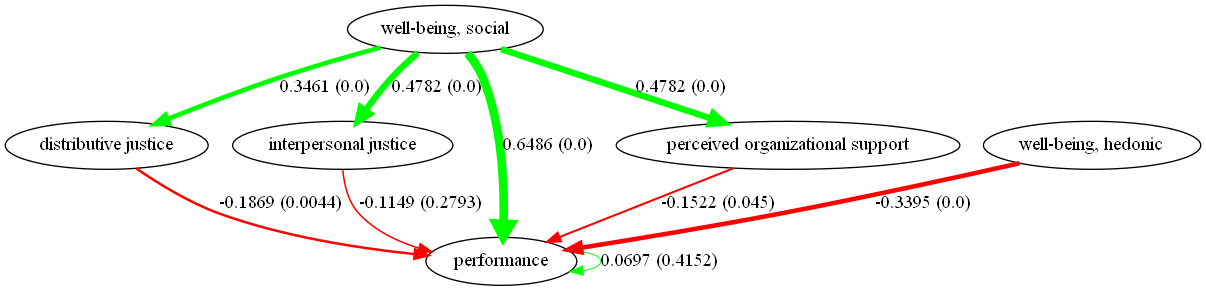

,c1.label1,c1.label2,c1.label3,c1.name,c2.label1,c2.label2,c2.label3,c2.name,mean corr,p-value
0,"well-being, social",,,,"well-being, social",justice,justice,distributive justice,0.3461,0.0000
1,"well-being, social",,,,"well-being, social",justice,justice,interpersonal justice,0.4782,0.0000
2,"well-being, social",,,,performance,performance,performance,performance,0.6486,0.0000
3,"well-being, social",justice,justice,distributive justice,performance,,,,-0.1869,0.0044
4,"well-being, social",justice,justice,interpersonal justice,performance,,,,-0.1149,0.2793
5,performance,performance,performance,performance,performance,,,,0.0697,0.4152
6,"well-being, social",,,,"well-being, social",workplace support,workplace support,perceived organizational support,0.4782,0.0000
7,"well-being, social",workplace support,workplace support,perceived organizational support,performance,,,,-0.1522,0.0450
8,"well-being, hedonic",,,,performance,,,,-0.3395,0.0000



    Notes: 
    [1] link label shows the mean effect size (p-value in the parenthesis); 
    [2] link arrow shows the direction of causality; 
    [3] link color suggests the sign of the effect size: green for positive, and red for negative;
    [4] link thickness suggests the magnitude of the effect size.
    


In [16]:
causal_graph(n1_level='label1', 
             n2_level='label1',
             n1_searchterm='well-being',
             n2_searchterm='performance',
             search_method='contain',
             draw_graph=True
            )